<a href="https://colab.research.google.com/github/renan-estatistica/notebooksAulaRedesNeuraisInpe/blob/main/Projeto_2_Redes_Para_Problemas_N%C3%A3o_Supervisionados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Renan Santos Barbosa

# Introdução

Neste projeto iremos realizar a análise de dois conjuntos de dados:

* Dados de Critical Heat FLux
* Dados Bancários de Aceitação de Campanhas de Marketing

Iremos ver em prática a aplicação do algoritmo SOM (Self Organizing Maps) na linguagem python. 
Esperamos nestes conjuntos identificar grupos de características que possam definir de forma mais simples os nossos dados (clustering).

# Pacotes e Funções Utilizadas

Abaixo seguem as bibliotecas e funções utilizadas nos estudos aplicados neste projeto. As funções para visualização não são de autoria própria, no entanto, algumas mudanças foram realizadas para se adequarem aos dados usados no projeto. Agradeço desde já o autor pela contribuição com as funções de modelagem, a devida referência está atribuída no final do relatório.

In [1]:
# caregamento das bases
!pip install -q MiniSom 
from minisom import MiniSom
import pandas as pd
import numpy as np
import seaborn as sn
from plotnine import *
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
# semente para fixar os resultados
np.random.seed(1000) 

In [2]:
def umatrix(som_model, use_colorbar=True, transpose=False, **kwargs):
    """Plot Self-organizing Map U-Matrix
    
    Args:
        som_model (minisom.MiniSom): MiniSom Model
        
        use_colorbar (bool): Flag para ativar colorbar no plot
        
        kwargs (dict): Parâmetros para a função to matplotlib.pyplot.imshow
    Returns:
        matplotlib.figure.Figure: grid figure
    """   

    distance_map = som_model.distance_map()
    
    if transpose:
        distance_map = distance_map.T[::-1]

    im = plt.imshow(distance_map, **kwargs)
    if use_colorbar: plt.colorbar(im)

def umatrix_labeled(som_model, 
                    data, 
                    labels, 
                    colors, 
                    markers, 
                    use_colorbar=True,
                    plot_lbl_args=None,
                    **kwargs):
    """Plot U-Matrix com label em cada neurônio
    
    Args:
        som_model (minisom.MiniSom): MiniSom Model
        
        data (np.ndarray): n-dimensional array para estimular os neurônios
        e gerar o mapa de ativação
        
        labels (np.ndarray): 1-dimensional array com as labels. precisa ser valores 
        inteiros discretos (e. g. 0, 1, 2, ...)
        
        colors (list): Cores para cada uma das classes (Considera a posição com o label da classe)
        (e. g. classe 1 será a posição 1 desta lista)
        
        markers (list): Markers para cada uma das classes (Considera a posição)
        (e. g. classe 1 será a posição 1 desta lista)
        
        use_colorbar (bool): Flag para ativar colorbar no plot
        
        plot_lbl_args (dict): Parâmetros para a função matplotlib.pyplot.plot utilizada no plot
        das labels
        
        kwargs (dict): Parâmetros para a função to matplotlib.pyplot.imshow
    Returns:
        None
    """
    
    if not plot_lbl_args:
        plot_lbl_args = {
            'markerfacecolor': 'None',
            'markersize': 12,
            'markeredgewidth': 2
        }
    
    im = plt.imshow(som_model.distance_map(), **kwargs)
    if use_colorbar: plt.colorbar(im)
    
    for idx, de in enumerate(data):
        label_idx = labels[idx] - 1
        
        winner = som_model.winner(de)
        plt.plot(winner[1], winner[0], 
                 markers[label_idx], 
                 markeredgecolor=colors[label_idx],
                 **plot_lbl_args)

def heatmap(som_model, feature_names, grid_spec, use_colorbar=True, **kwargs):
    """Plot Self-organizing map heatmap
    
    Args:
        som_model (minisom.MiniSom): MiniSom Model
        
        feature_names (list): Lista com o nome das labels
        
        grid_spec (tuple): Tupla com a quantidade de linhas e colunas do grid
        onde o heatmap será gerado
        
        use_colorbar (bool): Flag para ativar colorbar no plot
  
        kwargs (dict): Parâmetros para a função to matplotlib.pyplot.imshow
    Returns:
        None
    """

    weights = som_model.get_weights()
    
    for i, fname in enumerate(feature_names):
        plt.subplot(*grid_spec, i + 1)
        plt.title(fname)
        im = plt.imshow(weights[:, :, i], **kwargs)
        
        if use_colorbar: plt.colorbar(im)

def hitmap(som_model, data, use_colorbar=True, transpose=False, **kwargs):
    """Plot Self-organizing map hitmap
    
    Args:
        som_model (minisom.MiniSom): MiniSom Model
        
        data (np.ndarray): n-dimensional array para estimular os neurônios
        e gerar o mapa de ativação
        
        use_colorbar (bool): Flag para ativar colorbar no plot
        
        transpose (bool): Transpoe e inverte a matriz
        
        kwargs (dict): Parâmetros para a função to matplotlib.pyplot.imshow
    Returns:
        None
    """     
    frequencies = som_model.activation_response(data.to_numpy()).astype(int)
    
    if transpose:
        frequencies = frequencies.T[::-1]

    im = plt.imshow(frequencies, **kwargs)
    if use_colorbar: plt.colorbar(im)
    
    for (i, j), value in np.ndenumerate(frequencies):
        plt.text(j, i, value, verticalalignment='center', 
                              horizontalalignment='center')

def test1_plot_multi_som_maps(som_model: 'minisom.MiniSom', data: 'pd.DataFrame', **kwargs) -> None:
    """Função para visualizar U-Matrix, hitmap e heatmap do teste 1 do experimento 2
    
    Args:
        som_model (minisom.MiniSom): Instância MiniSom
        
        data (sklearn.utils.Bunch): Bunch de dados carregados do sklearn
    Returns:
        None
    """ 
    
    def plot_heat_map_som(som_model, data, **kwargs):
        """Função para visualizar U-Matrix, hitmap e heatmap

        Args:
            som_model (minisom.MiniSom): Instância MiniSom

            data (pd.DataFrame): Pandas DataFrame contendo as labels das variaveis
        Returns:
            None
        """      
        # get grid shape
        grid_shape = som_model.get_weights().shape[0:2]

        plt.figure(**kwargs)
        heatmap(som_model, data.columns, (4, 4), cmap='Reds')
        plt.suptitle('heatmap')
        
        plt.show()
    
    plt.figure(**kwargs)
    
    plt.subplot(2, 2, 1)
    umatrix(som_model, cmap='Reds')
    plt.title('U-Matrix')
    
    plt.subplot(2, 2, 2)
    hitmap(som_model, data, cmap='Reds')
    plt.title('hitmap')

    plt.show()
    plot_heat_map_som(som_model, data, **kwargs)


def manual_random_training(som_model, data, max_iter) -> pd.DataFrame:
    """Função para treinamento da rede SOM com amostragem aleatória.
    
    Args:
        som_model (minisom.MiniSom): Instância MiniSom treinada

        data (np.ndarray): array n-dimensional com os dados utilizados no treinamento
        
        max_iter (int): Quantidade máxima de iterações
    
    Returns:
        pd.DataFrame: Tabela com os erros de quantização e topográficos gerados
    See:
        https://github.com/JustGlowing/minisom/blob/master/examples/BasicUsage.ipynb
    """
    
    errors = {
        'qerror': [],
        'terror': []
    }
    
    for idx in range(max_iter):
        #print("% execução:",(idx/max_iter)*100)
        data_random = data[np.random.randint(len(data))]
        
        som_model.update(data_random, som_model.winner(data_random), idx, max_iter)
        
        errors['qerror'].append(som_model.quantization_error(data))
        errors['terror'].append(som_model.topographic_error(data))
    return pd.DataFrame(errors)



# Clusterização Com Redes SOM Para Dados De CHF

Para a primeira base iremos abordar a clusterização na base de predição do CHF (*Critical Heat Flux*). Apesar de ser um conjunto de dados pequeno com poucas variáveis e observações, estou estudando o problema da predição do chf no meu mestrado.
Iremos utilizar a clusterização para identificar se é possível identificar diferenças entre os diferentes tipos de geometria para o experimento, para o futuro enriquecimento da abordagem do projeto.
Os problemas relacionados à estimação do CHF estão relacionados a transferência de calor, máquina de calor, entre outros.
O CHF pode ser considerado como o limite térmico de um fenomeno onde a ocorrência da mudança de fase durante o aquecimento o que pode gerar uma queda repentina na eficiência da transferência de calor o que pode causar um superaquecimento na superfície aquecida. 
Um exemplo é um tubo sendo e água como líquido refrigerante, ao aquecer o tubo e o mesmo alcançar o limite do chf bolhas começam a se formar ao redor do tubo formando uma "camada" de ar entre o tubo e a água reduzindo a capacidade de transferência do calor do tubo para a água o que causa um superaquecimento que pode derreter o tubo dependendo do material utilizado.
Um exemplo do comportamento do fluxo de calor ao longo da variação da temperatura é apresentado abaixo juntamente com o o ponto **E** representando o momento em que o fluxo apresenta seu limite juntamente com a temperatura:

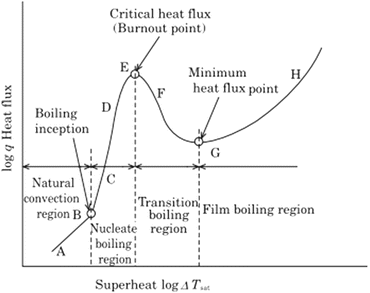



Os dados utilizados é um compilado de vários exprimentos realizados por diferentes autores onde temos observadas diversas variáveis relacionadas aos experimentos realizados. Localização da base no kaggle: https://www.kaggle.com/datasets/saurabhshahane/predicting-heat-flux


## Limpeza dos Dados

In [154]:
dados_chf = pd.read_csv("Data_CHF_Zhao_2020_ATE.csv")

In [155]:
# realizando a limpeza dos dados iremos remover as informacoes de ID e autor pois estas nao comtribuem para a modelagem

dados_chf.drop(labels = ["id","author"], axis = 1, inplace = True)

In [156]:
dados_chf.head()

,geometry,pressure [MPa],mass_flux [kg/m2-s],x_e_out [-],D_e [mm],D_h [mm],length [mm],chf_exp [MW/m2]
0,tube,0.39,5600,-0.1041,3.0,3.0,100,11.3
1,tube,0.31,6700,-0.0596,3.0,3.0,100,10.6
2,tube,0.33,4300,-0.0395,3.0,3.0,100,7.3
3,tube,0.62,6400,-0.1460,3.0,3.0,100,12.8
4,tube,0.64,4700,-0.0849,3.0,3.0,100,11.0


In [157]:
dados_chf.shape

(1865, 8)

In [158]:
# renomeando as colunas para formatacao code friendly

dados_chf.columns = ["geometry","pressure","mass_flux","x_e_out","d_e","d_h","lenght","chf_exp"]

In [159]:
dados_chf.columns.values

array(['geometry', 'pressure', 'mass_flux', 'x_e_out', 'd_e', 'd_h',
       'lenght', 'chf_exp'], dtype=object)

Iremos verificar a distribuição dos dados com relação aos diferentes tipos de geometrias dos experimentos.

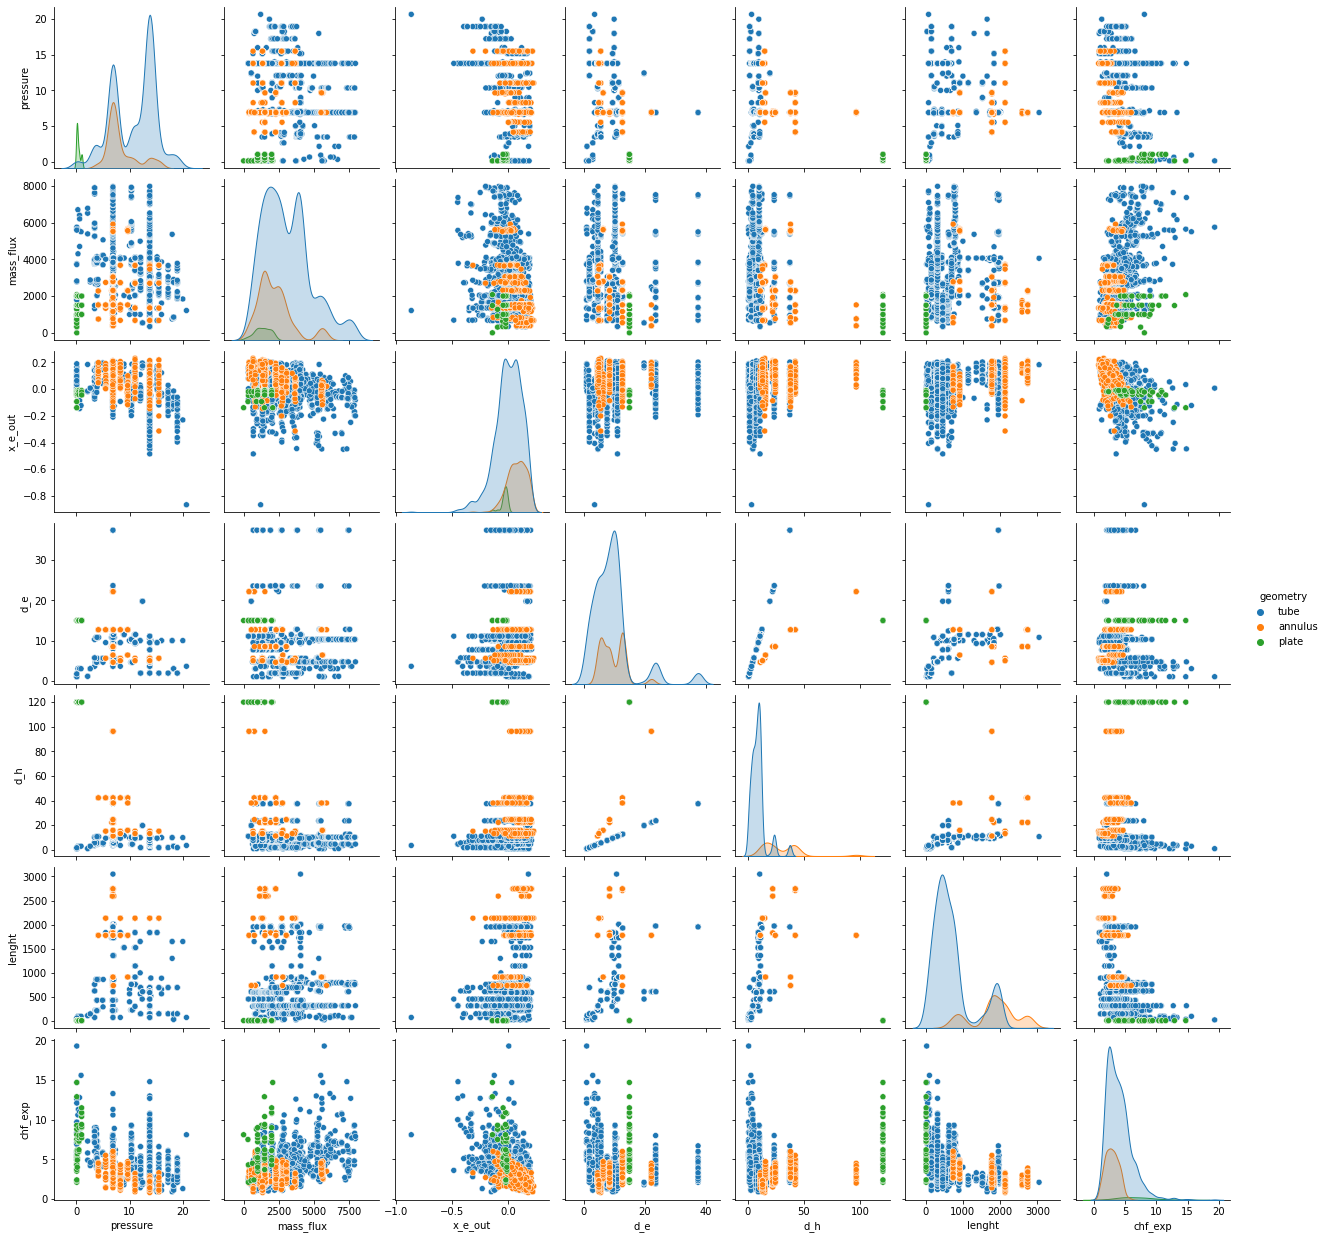

In [160]:
sn.pairplot(dados_chf, hue = 'geometry')

Podemos verificar que as distribuições das variáveis por geometria se apresentam de forma parecida o que pode dificultar o processo de modelagem para identificação de clusters bem definidos.

In [161]:
# iremos remover a variavel categorica da analise
geometry = dados_chf.geometry
dados_chf.drop(columns=["geometry"],inplace = True)

In [162]:
dados_chf.head()

,pressure,mass_flux,x_e_out,d_e,d_h,lenght,chf_exp
0,0.39,5600,-0.1041,3.0,3.0,100,11.3
1,0.31,6700,-0.0596,3.0,3.0,100,10.6
2,0.33,4300,-0.0395,3.0,3.0,100,7.3
3,0.62,6400,-0.1460,3.0,3.0,100,12.8
4,0.64,4700,-0.0849,3.0,3.0,100,11.0


In [163]:
# normalizando os dados

max_treino = dados_chf.max()
min_treino = dados_chf.min()
x_normalizado = (dados_chf-min_treino)/(max_treino-min_treino)
x_np = x_normalizado.to_numpy()


## Ajuste do Modelo

Iremos testar alguns tipos diferentes de dimensão da rede SOM para o ajuste e teste da qualidade do ajuste.

In [164]:
# parametros de inicialização do modelo
som_grid_rows = 10
som_grid_columns = 10
iterations = 20000
sigma = 0.6
learning_rate = 0.6


In [165]:
# define SOM:
som = MiniSom(x = som_grid_rows, y = som_grid_columns, input_len=7, sigma=sigma, learning_rate=learning_rate)

# treinamento da rede aleatória
modelo_ajustado = manual_random_training(som, x_np, iterations)

In [166]:
# erro topográfico da rede
print("Erro Topográfico",som.topographic_error(x_np))
# quantização do erro 
print("Erro Quantizado",som.quantization_error(x_np))

Erro Topográfico 0.37211796246648793
Erro Quantizado 0.09552757017485608


In [167]:
erros_ajuste = modelo_ajustado.melt(ignore_index = False)

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


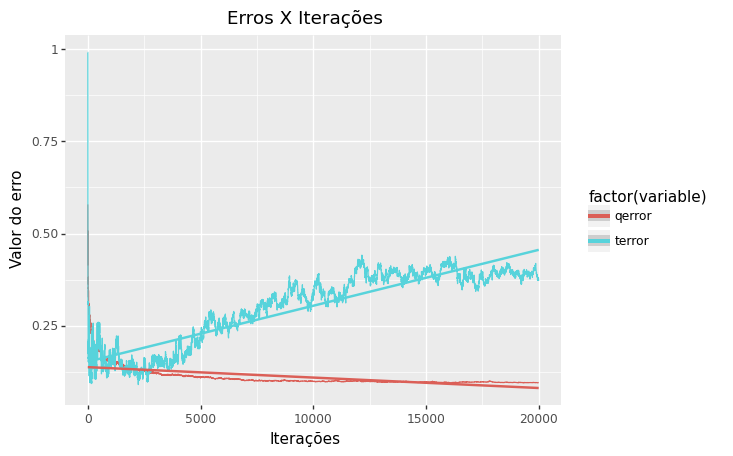

<ggplot: (8735906438289)>

In [168]:
(
    ggplot(erros_ajuste, aes(x = "erros_ajuste.index", y = "value", color='factor(variable)'))
        + geom_line()
        + stat_smooth(method='lm')
        + xlab("Iterações")
        + ylab("Valor do erro")
        + ggtitle("Erros X Iterações")
)

Verificamos que aproximadamente após 3 mil iterações o erro topográfico volta a crescer enquanto o erro quantizado se mantém pequeno com pouca redução, iremos reduzir o numero de iterações para evitar o aumento do erro topográfico.

In [169]:
x_np.shape

(1865, 7)

In [170]:
# parametros de inicialização do modelo com alteração de alguns parametros do ajuste
# alteracao no sigma, learning rate e numero de iterações
som_grid_rows = 10
som_grid_columns = 10
iterations = 1500
sigma = 0.7
learning_rate = 0.5


In [171]:
# define SOM:
som = MiniSom(x = som_grid_rows, y = som_grid_columns, input_len=7, sigma=sigma, learning_rate=learning_rate)

# treinamento da rede aleatória
modelo_ajustado = manual_random_training(som, x_np, iterations)

In [172]:
# erro topográfico da rede
print("Erro Topográfico",som.topographic_error(x_np))
# quantização do erro 
print("Erro Quantizado",som.quantization_error(x_np))

Erro Topográfico 0.34584450402144773
Erro Quantizado 0.14668505558311998


In [173]:
erros_ajuste = modelo_ajustado.melt(ignore_index = False)

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


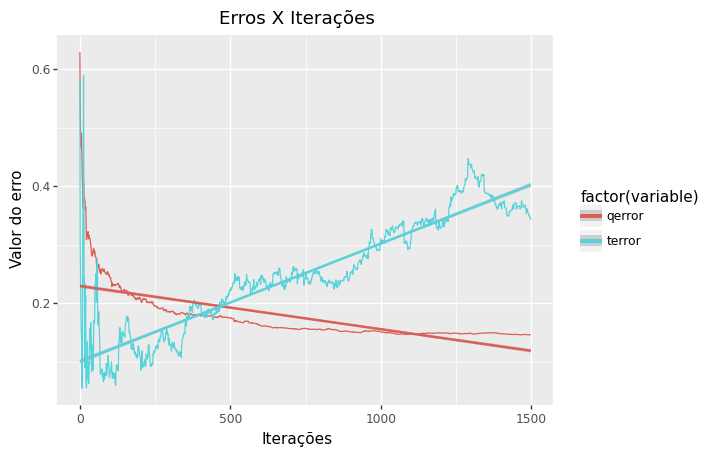

<ggplot: (8735907702049)>

In [174]:
(
    ggplot(erros_ajuste, aes(x = "erros_ajuste.index", y = "value", color='factor(variable)'))
        + geom_line()
        + stat_smooth(method='lm')
        + xlab("Iterações")
        + ylab("Valor do erro")
        + ggtitle("Erros X Iterações")
)

Realizei diversos testes com sigmas e learning_rates variando, o numero de iterações maior causou um maior valor do erro topográfico, possívelmente isso pode ser um indicio da topografia selecionado não ser a mais adequada para os dados. Iremos gerar algumas visualizações com mapas de calor para entender melhor as características compreendidas pelo modelo.

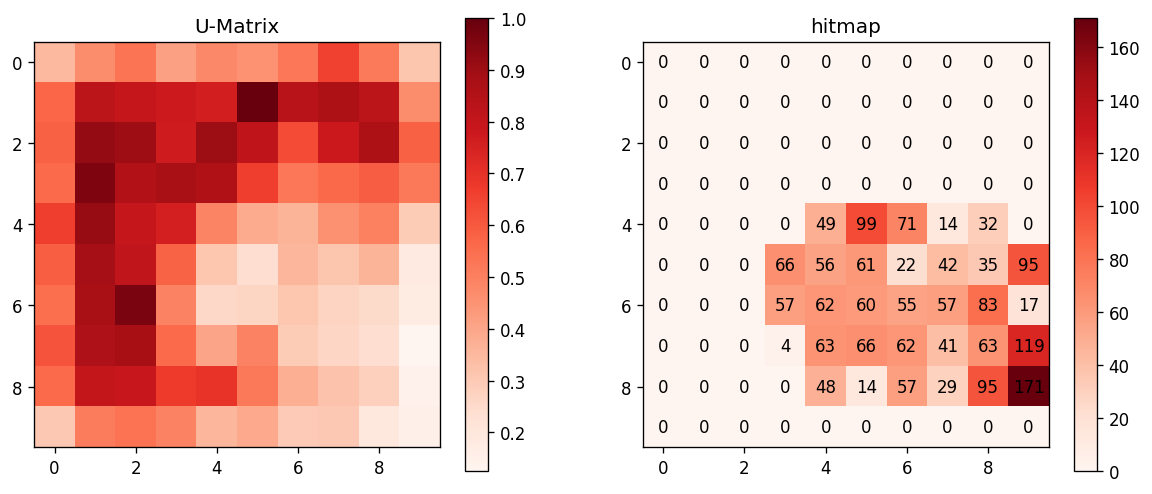

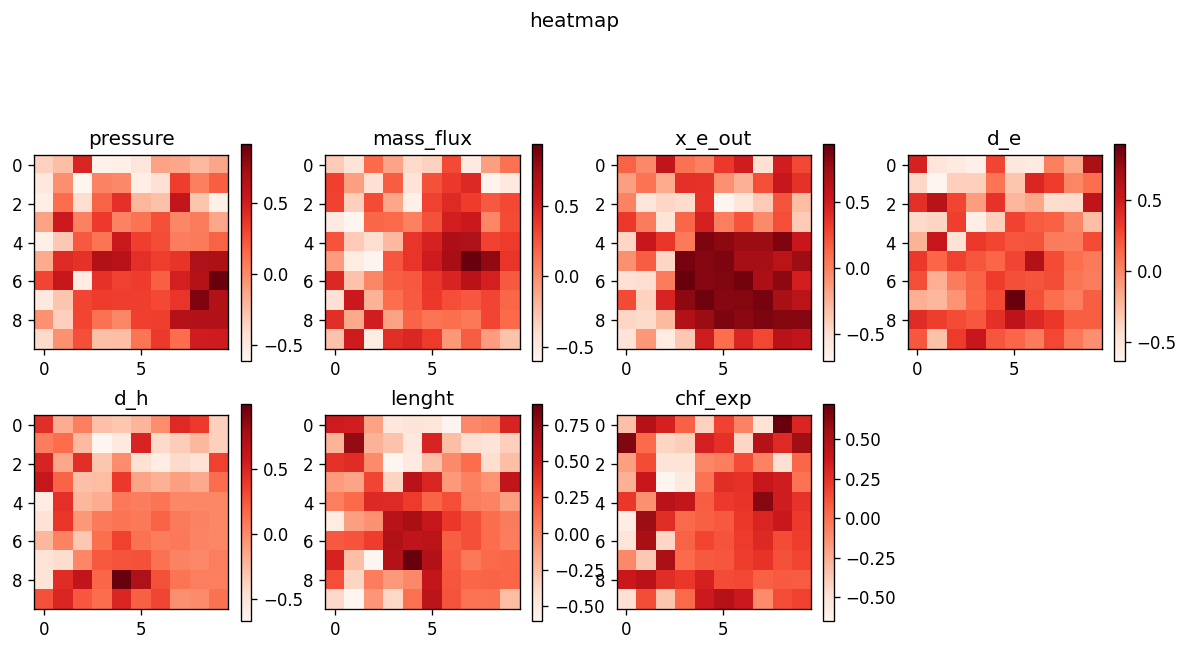

In [175]:
test1_plot_multi_som_maps(som, x_normalizado, dpi=120, figsize=(12, 11))

In [219]:
# substituindo os nomes categoricos por valores para gerar o grafico
geometry_rep = geometry.replace("tube",0) # cor laranja
geometry_rep = geometry_rep.replace("annulus",1)  # cor azul
geometry_rep = geometry_rep.replace("plate",2) # cor verde
geometry_arr = geometry_rep.values

In [220]:
geometry_rep.value_counts()

0    1439
1     378
2      48
Name: geometry, dtype: int64

Text(0.5, 1.0, 'SOM (10x10) \n lr = 0.5, alpha0.7')

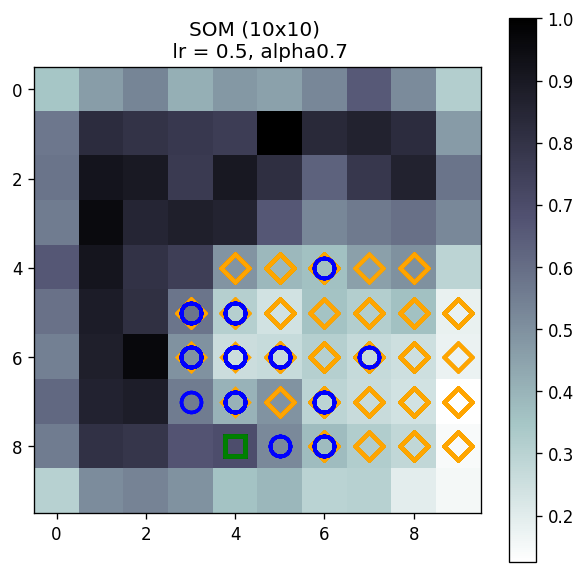

In [221]:
plt.figure(dpi = 120, figsize = (6, 6))

colors = ['blue', 'green', 'orange']
markers = ['o', 's', 'D']

geometry

umatrix_labeled(som, x_np , geometry_arr, colors, markers, cmap = 'bone_r')
plt.title('SOM (10x10) \n lr = 0.5, alpha0.7')

Podemos notar que a classe "plate" representado pelo quadrado verde pode ser separado da base em apenas um cluster, no entanto, podemos ver que para as outras classes temos clusters especializados para a classe "tube" porém a classe "annulus" compartilha dos mesmos neuronios, dando indicios que os dados possuem características parecidas dificuldando a clusterização eficiente. Podemos verificar também que os neuronios encontram-se próximos uns dos outros, logo iremos reduzir o tamanho do grid em um novo modelo e verificar se o erro da topologia reduz e a separação das classes fica melhor definida.

In [277]:
# parametros de inicialização do modelo com alteração de alguns parametros do ajuste
# grid, alteracao no sigma, learning rate e numero de iterações
som_grid_rows = 3
som_grid_columns = 3
iterations = 1500
sigma = 0.8
learning_rate = 0.7


In [278]:
# define SOM:
som = MiniSom(x = som_grid_rows, y = som_grid_columns, input_len=7, sigma=sigma, learning_rate=learning_rate)

# treinamento da rede aleatória
modelo_ajustado = manual_random_training(som, x_np, iterations)

In [279]:
# erro topográfico da rede
print("Erro Topográfico",som.topographic_error(x_np))
# quantização do erro 
print("Erro Quantizado",som.quantization_error(x_np))

Erro Topográfico 0.0418230563002681
Erro Quantizado 0.2295086860329784


In [280]:
erros_ajuste = modelo_ajustado.melt(ignore_index = False)

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


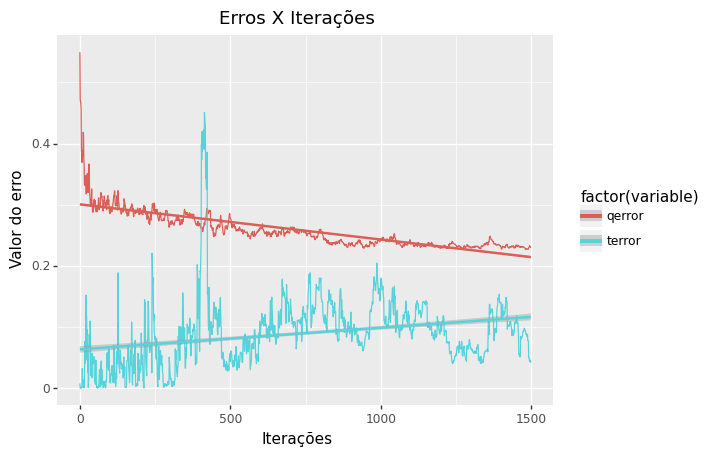

<ggplot: (8735885117333)>

In [281]:
(
    ggplot(erros_ajuste, aes(x = "erros_ajuste.index", y = "value", color='factor(variable)'))
        + geom_line()
        + stat_smooth(method='lm')
        + xlab("Iterações")
        + ylab("Valor do erro")
        + ggtitle("Erros X Iterações")
)

Foi realizados alguns testes com de variação de parametros com a rede do tipo 3x3, no entanto,  uma pequena variação dos parametros causa uma discrepância nos resultados grande, acima foi selecionado o melhor resultado obtido, no entanto, isso pode ser um indicio de como a separação das classes é complexa para os dados selecionados.

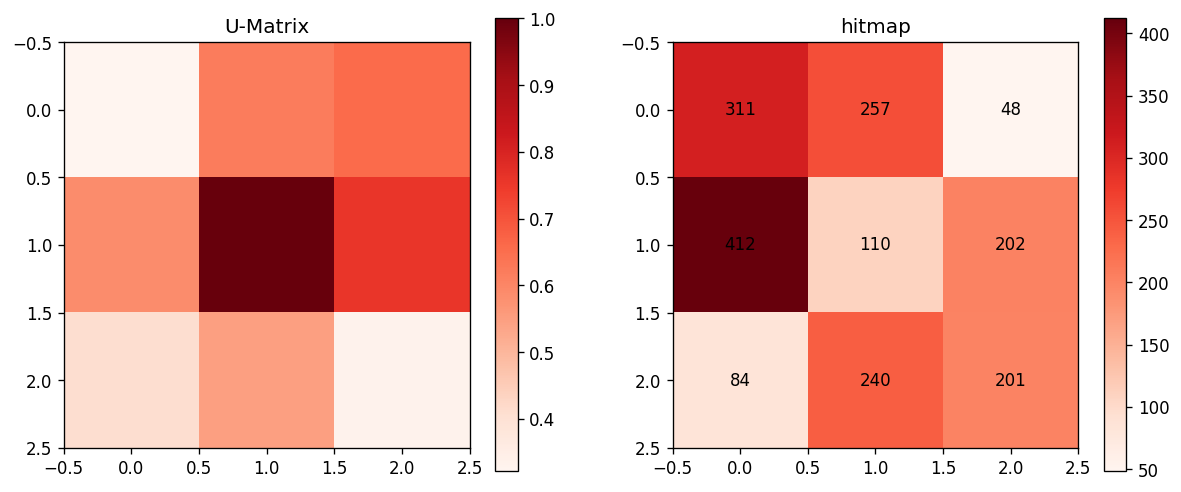

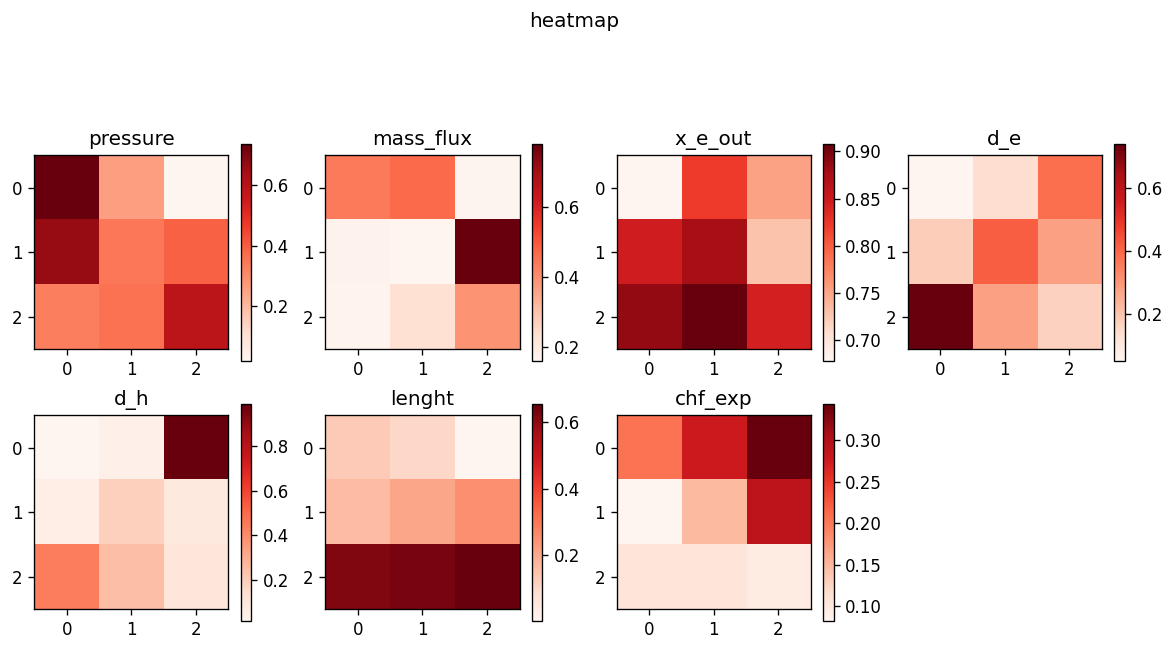

In [282]:
test1_plot_multi_som_maps(som, x_normalizado, dpi=120, figsize=(12, 11))

In [283]:
# substituindo os nomes categoricos por valores para gerar o grafico
geometry_rep = geometry.replace("tube",0) # cor laranja
geometry_rep = geometry_rep.replace("annulus",1)  # cor azul
geometry_rep = geometry_rep.replace("plate",2) # cor verde
geometry_arr = geometry_rep.values

In [284]:
geometry_rep.value_counts()

0    1439
1     378
2      48
Name: geometry, dtype: int64

Text(0.5, 1.0, 'SOM (10x10) \n lr = 0.5, alpha0.7')

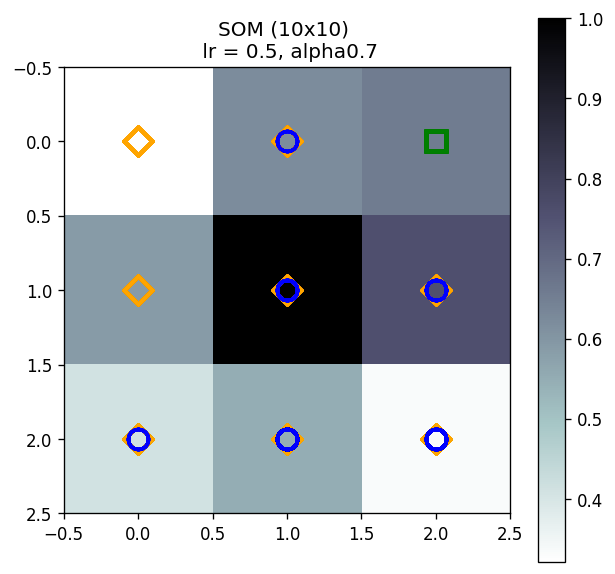

In [285]:
plt.figure(dpi = 120, figsize = (6, 6))

colors = ['blue', 'green', 'orange']
markers = ['o', 's', 'D']

geometry

umatrix_labeled(som, x_np , geometry_arr, colors, markers, cmap = 'bone_r')
plt.title('SOM (3x3) \n lr = 0.5, alpha0.7')

Podemos notar que a classe "plate" representado pelo quadrado verde pode ser separado da base em apenas um cluster, no entanto, podemos ver que para as outras classes temos clusters especializados para a classe "tube" porém a classe "annulus" compartilha dos mesmos neuronios, dando indicios que os dados possuem características parecidas dificuldando a clusterização eficiente. 

## Considerações Finais Para a Base

Após as análises realizadas, notamos que os experimentos com geometria "plate" é o único com capacidade de ser separado de forma clara pelo modelo de redes SOM independente da arquitetura, logo, podemos considerar em futuros estudos de regressão a remoção dos dados do tipo "plate" para a predição do *CHF* já que suas características diferem dos demais dados.

# Clusterização de Dados Bancários Com Redes SOM

Neste desafio iremos abordar a clusterização de clientes de um banco português, onde iremos avaliar a efetividade de campanhas de marketing baseado em características dos clientes. 
O desafio nesta base é que iremos usar apenas variáveis categoricas na base, logo os pesos irão se adequar pela proporção de clientes que melhor se adaptam aquele neuronio. Apesar de termos a variável resposta do sucesso ou não dessa campanha iremos aplicar uma abordagem não supervisionada para entender melhor quais as características dos clientes que aceitaram ou não uma proposta de marketing.

Os dados podem ser obtidos em : [Bank Costumer Clustering](https://www.kaggle.com/code/ashydv/bank-customer-clustering-k-modes-clustering/data)

## Limpeza dos Dados

In [3]:
dados_bank = pd.read_csv("bankmarketing.csv")

In [4]:
# as variáveis estao descritas no link dos dados
labels = dados_bank.y
dados_bank = dados_bank[['job', 'marital', 'education', 'default', 'housing', 'loan','contact','month','day_of_week','poutcome']]


In [5]:
dados_bank.head()

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome
0,housemaid,married,basic.4y,no,no,no,telephone,may,mon,nonexistent
1,services,married,high.school,unknown,no,no,telephone,may,mon,nonexistent
2,services,married,high.school,no,yes,no,telephone,may,mon,nonexistent
3,admin.,married,basic.6y,no,no,no,telephone,may,mon,nonexistent
4,services,married,high.school,no,no,yes,telephone,may,mon,nonexistent


In [6]:
dados_bank.shape

(41188, 10)

In [7]:
dados_bank.describe()

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome
count,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188
unique,12,4,8,3,3,3,2,10,5,3
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent
freq,10422,24928,12168,32588,21576,33950,26144,13769,8623,35563


In [8]:
# iremos verificar se existe dados faltantes na base

dados_bank.isnull().sum()*100/dados_bank.shape[0]

job            0.0
marital        0.0
education      0.0
default        0.0
housing        0.0
loan           0.0
contact        0.0
month          0.0
day_of_week    0.0
poutcome       0.0
dtype: float64

In [9]:
# transformação dos dados em valores binários para o ajuste do modelo

bank = pd.get_dummies(dados_bank)

In [10]:
bank.head()

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0


In [11]:
bank.describe()

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
count,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,...,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,0.253035,0.224677,0.035350,0.025736,0.070992,0.041760,0.034500,0.096363,0.021244,0.163713,...,0.017432,0.013839,0.190031,0.206711,0.209357,0.196416,0.197485,0.103234,0.863431,0.033335
std,0.434756,0.417375,0.184665,0.158348,0.256814,0.200042,0.182513,0.295092,0.144199,0.370019,...,0.130877,0.116824,0.392330,0.404951,0.406855,0.397292,0.398106,0.304268,0.343396,0.179512
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [12]:
bank.shape

(41188, 53)

In [13]:
# conversao dos dados para numpy array

bank_arr = bank.to_numpy()

## Ajuste do Modelo

In [20]:
# parametros de inicialização do modelo
som_grid_rows = 5
som_grid_columns = 5
iterations = 5000
sigma = 0.8
learning_rate = 0.7


In [21]:
# define SOM:
som_bank = MiniSom(x = som_grid_rows, y = som_grid_columns, input_len=bank.shape[1], sigma=sigma, learning_rate=learning_rate)

# treinamento da rede em batches pelo tamanho da base
som_bank.train_batch(bank_arr,iterations, verbose=True)

 [ 5000 / 5000 ] 100% - 0:00:00 left 
 quantization error: 2.410691843361311


In [22]:
# erro topográfico da rede
print("Erro Topográfico",som_bank.topographic_error(bank_arr))
# quantização do erro 
print("Erro Quantizado",som_bank.quantization_error(bank_arr))

Erro Topográfico 0.6156647567252598
Erro Quantizado 2.410691843361311


Text(0.5, 1.0, 'hitmap')

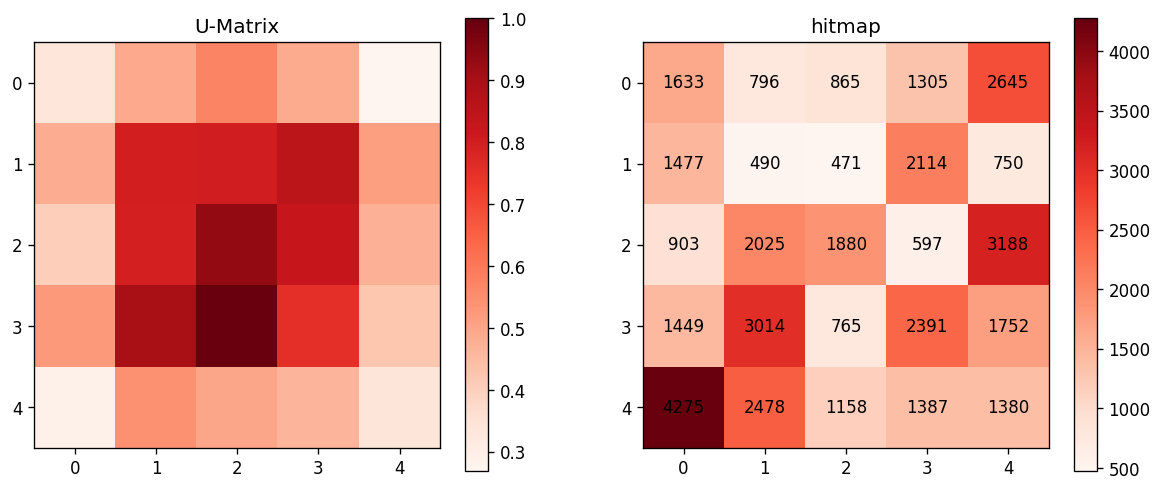

In [26]:
plt.figure(figsize=(12, 11), dpi=120)
plt.subplot(2, 2, 1)
umatrix(som_bank, cmap='Reds')
plt.title('U-Matrix')
    
plt.subplot(2, 2, 2)
hitmap(som_bank, bank, cmap='Reds')
plt.title('hitmap')

In [28]:
# substituindo os nomes categoricos por valores para gerar o grafico
labels_rep = labels.replace("no",0) 
labels_rep = labels_rep.replace("yes",1) 
labels_rep_arr = labels_rep.values

In [30]:
labels_rep.value_counts()

0    36548
1     4640
Name: y, dtype: int64

Text(0.5, 1.0, 'SOM (10x10) \n lr = 0.5, alpha0.7')

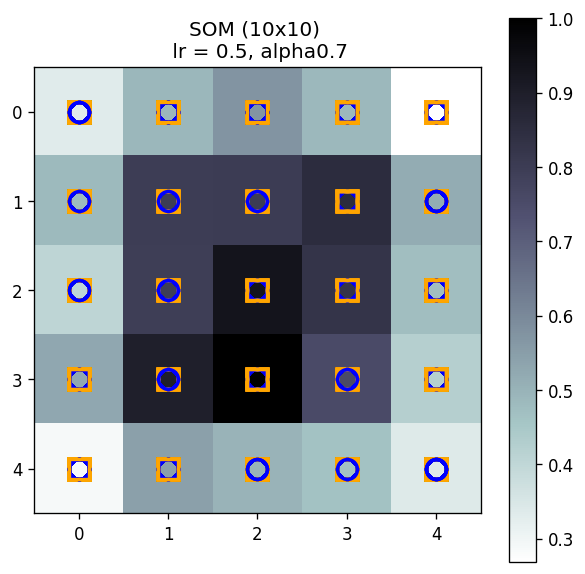

In [31]:
plt.figure(dpi = 120, figsize = (6, 6))

colors = ['blue', 'orange']
markers = ['o', 's']

umatrix_labeled(som_bank, bank_arr , labels_rep_arr, colors, markers, cmap = 'bone_r')
plt.title('SOM (10x10) \n lr = 0.5, alpha0.7')

Analisando os resultados apresentados verificamos a arquitetura apresentada não foi suficiente para separar os dados de forma eficiente, iremos testar uma arquitetura mais complexa e uma distância entre nós sigma menor para tornar a separação mais restrita.

In [37]:
# parametros de inicializacao do modelo
som_grid_rows = 20
som_grid_columns = 20
iterations = 20000
sigma = 0.5
learning_rate = 0.4


In [38]:
# define SOM:
som_bank = MiniSom(x = som_grid_rows, y = som_grid_columns, input_len=bank.shape[1], sigma=sigma, learning_rate=learning_rate)

# treinamento da rede em batches pelo tamanho da base
som_bank.train_batch(bank_arr,iterations, verbose=True)

 [ 20000 / 20000 ] 100% - 0:00:00 left 
 quantization error: 2.0157421945925735


In [39]:
# erro topográfico da rede
print("Erro Topográfico",som_bank.topographic_error(bank_arr))
# quantização do erro 
print("Erro Quantizado",som_bank.quantization_error(bank_arr))

Erro Topográfico 0.806909779547441
Erro Quantizado 2.0157421945925735


Text(0.5, 1.0, 'hitmap')

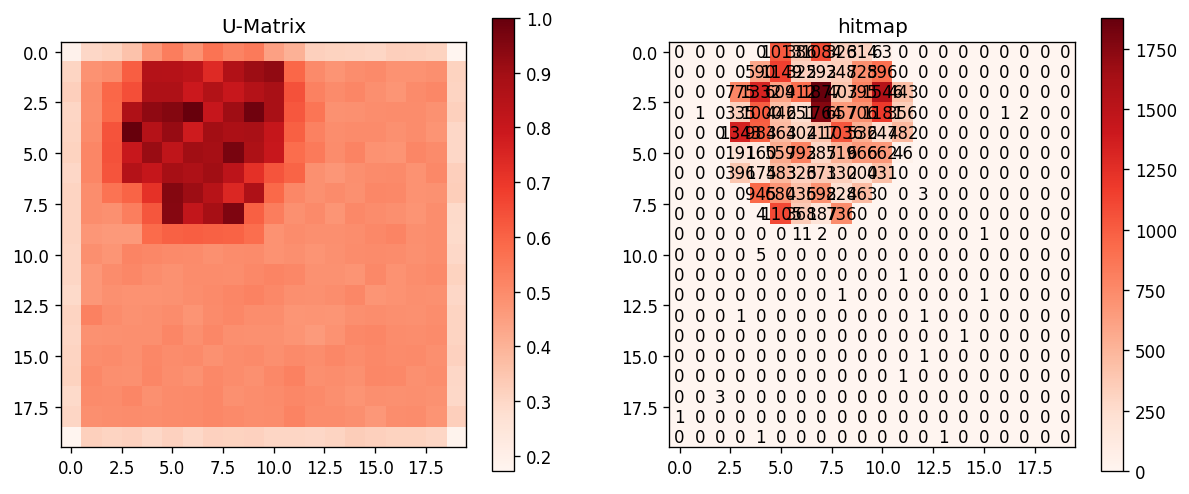

In [40]:
plt.figure(figsize=(12, 11), dpi=120)
plt.subplot(2, 2, 1)
umatrix(som_bank, cmap='Reds')
plt.title('U-Matrix')
    
plt.subplot(2, 2, 2)
hitmap(som_bank, bank, cmap='Reds')
plt.title('hitmap')

In [41]:
# substituindo os nomes categoricos por valores para gerar o grafico
labels_rep = labels.replace("no",0) 
labels_rep = labels_rep.replace("yes",1) 
labels_rep_arr = labels_rep.values

In [42]:
labels_rep.value_counts()

0    36548
1     4640
Name: y, dtype: int64

Text(0.5, 1.0, 'SOM (20x20) \n lr = 0.5, alpha0.7')

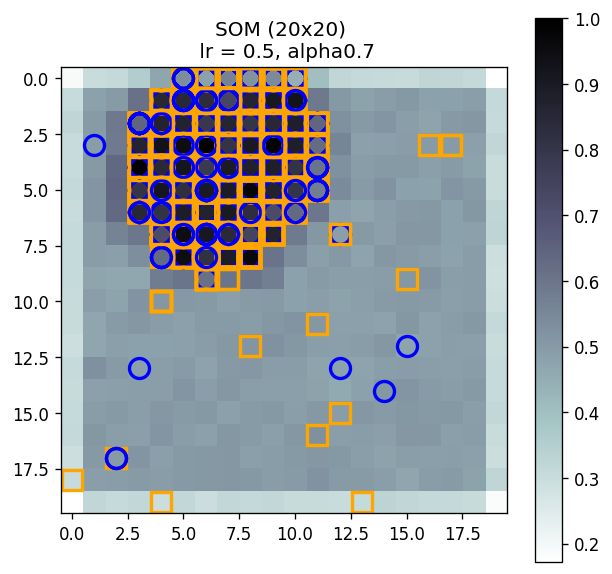

In [44]:
plt.figure(dpi = 120, figsize = (6, 6))

colors = ['blue', 'orange']
markers = ['o', 's']

umatrix_labeled(som_bank, bank_arr , labels_rep_arr, colors, markers, cmap = 'bone_r')
plt.title('SOM (20x20) \n lr = 0.5, alpha0.7')

Podemos verificar que mesmo com uma rede de maior dimensão os clusters se encontram pouco especializados no processo de separação das classes. Possívelmente pelo desbalanceamento dos dados usados, neste caso iremos ajustar os dados selecionando uma amostra dos dados de forma que os dados sejam balanceados.

In [46]:
bank["label"] = labels

In [47]:
# selecionando dados com categoria "yes"
bank_yes = bank[bank.label == "yes"]

In [50]:
# selecionando amostra aleatoria de mesmo tamanho da categoria "yes" para a categoria "no"

bank_no = bank[bank.label == "no"].sample(n = bank_yes.shape[0])

In [62]:
# juntando as bases

bank_sample = bank_yes.append(bank_no)

In [63]:
labels_sample = bank_sample.label
bank_sample.drop(columns = ["label"],inplace = True)

In [64]:
# amostra final utilizada
bank_sample.shape

(9280, 53)

In [65]:
# converter a amostra em numpy
bank_sample_arr = bank_sample.to_numpy()

In [66]:
# parametros de inicialização do modelo com alteração de alguns parametros do ajuste
# alteracao no sigma, learning rate e numero de iterações
som_grid_rows = 10
som_grid_columns = 10
iterations = 1500
sigma = 0.7
learning_rate = 0.5


In [67]:
# define SOM:
som_bank = MiniSom(x = som_grid_rows, y = som_grid_columns, input_len=bank_sample.shape[1], sigma=bank_sample.shape[1], learning_rate=learning_rate)

# treinamento da rede aleatória
modelo_ajustado = manual_random_training(som_bank,bank_sample_arr, iterations)

/usr/local/lib/python3.7/dist-packages/minisom.py:160: UserWarning: Warning: sigma is too high for the dimension of the map.
  warn('Warning: sigma is too high for the dimension of the map.')


In [69]:
# erro topográfico da rede
print("Erro Topográfico",som_bank.topographic_error(bank_sample_arr))
# quantização do erro 
print("Erro Quantizado",som_bank.quantization_error(bank_sample_arr))

Erro Topográfico 0.036853448275862066
Erro Quantizado 2.4054341943450357


In [70]:
erros_ajuste = modelo_ajustado.melt(ignore_index = False)

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


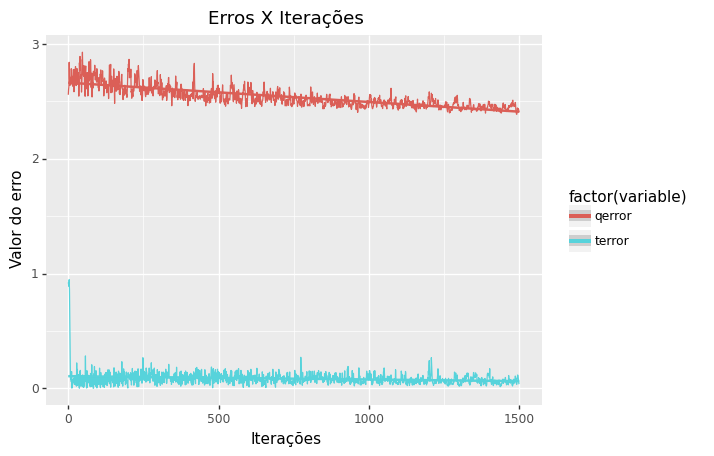

<ggplot: (8776371824577)>

In [71]:
(
    ggplot(erros_ajuste, aes(x = "erros_ajuste.index", y = "value", color='factor(variable)'))
        + geom_line()
        + stat_smooth(method='lm')
        + xlab("Iterações")
        + ylab("Valor do erro")
        + ggtitle("Erros X Iterações")
)

Text(0.5, 1.0, 'hitmap')

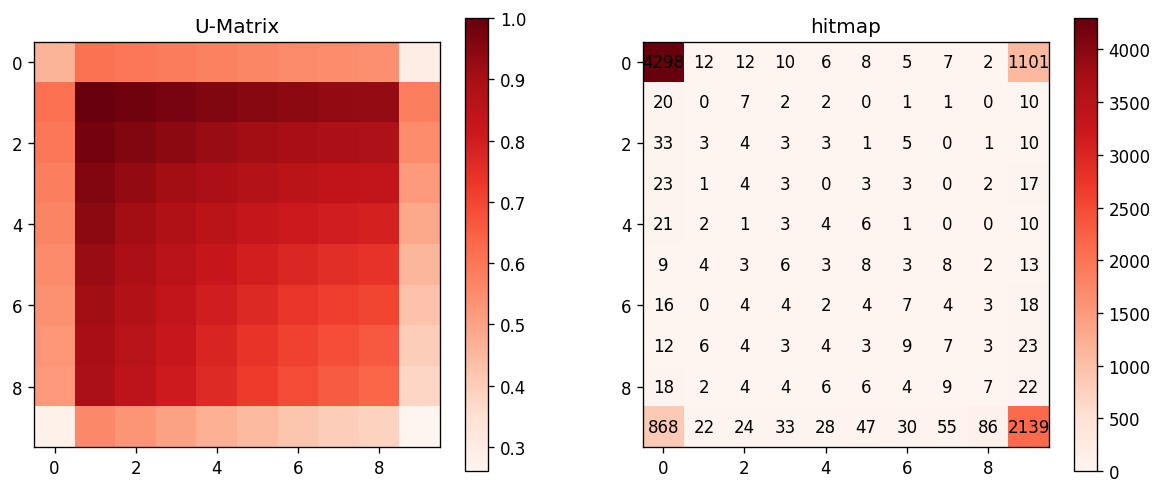

In [73]:
plt.figure(figsize=(12, 11), dpi=120)
plt.subplot(2, 2, 1)
umatrix(som_bank, cmap='Reds')
plt.title('U-Matrix')
    
plt.subplot(2, 2, 2)
hitmap(som_bank, bank_sample, cmap='Reds')
plt.title('hitmap')

In [74]:
# substituindo os nomes categoricos por valores para gerar o grafico
labels_rep = labels_sample.replace("no",0) 
labels_rep = labels_rep.replace("yes",1) 
labels_rep_arr = labels_rep.values

In [75]:
labels_rep.value_counts()

1    4640
0    4640
Name: label, dtype: int64

Text(0.5, 1.0, 'SOM (10x10) \n lr = 0.5, alpha0.7')

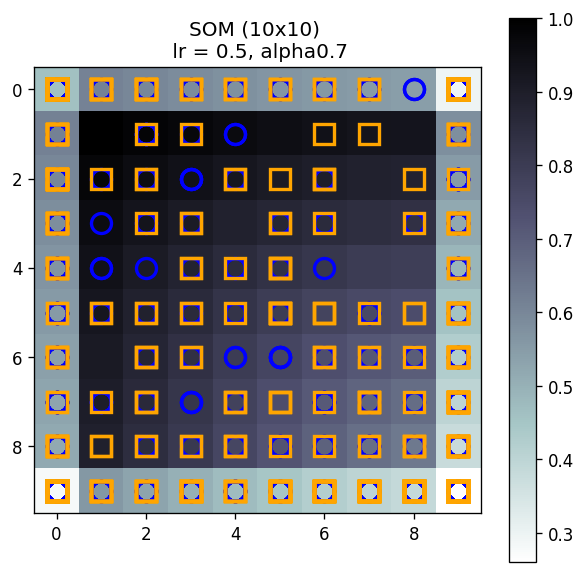

In [77]:
plt.figure(dpi = 120, figsize = (6, 6))

colors = ['blue', 'orange']
markers = ['o', 's']

umatrix_labeled(som_bank, bank_sample_arr , labels_rep_arr, colors, markers, cmap = 'bone_r')
plt.title('SOM (10x10) \n lr = 0.5, alpha0.7')

# Considerações Finais Para a Base

Para o estudo realizado mesmo com o ajuste da base de dados não conseguimos obter resultados satisfatórios para a clusterização, as possíveis causas podem ser:

* Modelo inadequado para a problemática, modelo talvez não seja o mais adequado para resolver esse tipo de desafio, o teste de outros algoritmos poderiam trazer resultados mais eficientes;
* variáveis confundidoras que misturam as características que definem as classes;
* Arquiteturas testadas inadequadas, a utilização de outras arquiteturas talvez poderiam solucionar o desafio.

# Referências 

* [Slides de Aula](https://)

* [Redes SOM](https://medium.com/@yolandawiyono98/introducing-self-organising-maps-som-2b6af3e9b0ff)


* [Erro Topográfico, Erro Quantização](https://www.intechopen.com/chapters/69305)


* [U-matrix](https://users.ics.aalto.fi/jhollmen/dippa/node24.html)


* [Exemplos de Ajuste MiniSom](https://github.com/JustGlowing/minisom/tree/master/examples)

* [Funções de Gráficos](https://www.kaggle.com/code/phelpsmemo/cap-351-neurocomputacao-projeto2-som)